In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

import cv2
import matplotlib.pyplot as plt

In [2]:
PATH = Path("/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs")
list(PATH.iterdir())

[PosixPath('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/.DS_Store'),
 PosixPath('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/test'),
 PosixPath('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train')]

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

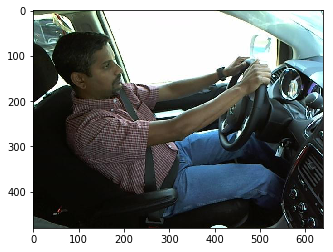

In [4]:
path = PATH/"train/c0/img_34.jpg"
im = read_image(path)
plt.imshow(im)

In [5]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(480, 640, 3)

In [6]:
# let's look at the typical size of these images
path = PATH/"train/c0"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]
dims[:10]

[(480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3)]

In [7]:
# let's look at the typical size of these images
path = PATH/"train/c1"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]
dims[:10]

[(480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3)]

All pirctures are 480x640 with 3 channels.

## Data augmentation
(Avoid overfitting)

In [8]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

**Center crop**

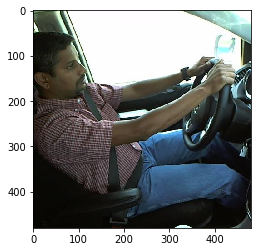

In [9]:
path = PATH/"train/c0/img_34.jpg"
im = read_image(path)
im = center_crop(im)
plt.imshow(im, cmap='gray')

In [10]:
im.shape

(480, 480, 3)

## Random crop...??

In [13]:
path = PATH/"train/c0/img_34.jpg"
im = read_image(path)

In [15]:
im.shape

(480, 640, 3)

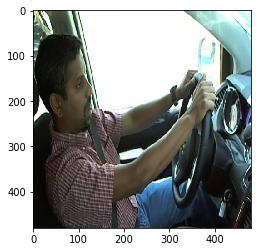

In [16]:
path = PATH/"train/c0/img_34.jpg"
im = read_image(path)

im = cv2.resize(im, (int(480*1.1), int(640*1.1)))
im2 = random_crop(im, 480, 480)
plt.imshow(im2)

## Random rotation

-0.6245611550475405


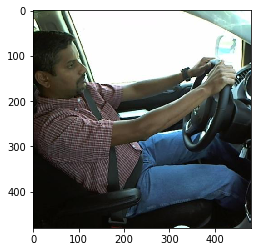

In [11]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

In our case does horizontal flip make sense?

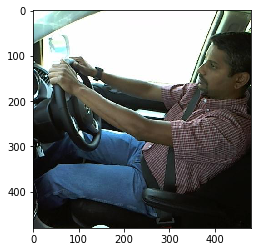

In [12]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

I think center cropping and some rotation will be enough for now

## Dataset

For now we will resize all images to 240 by 240 after center cropping and rotate the images in the training set by some random amount of degrees.

In [13]:
PATH

PosixPath('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs')

In [14]:
# When using pre-trained networks you should normalized your images in the same way the
# authors of the model did.
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [15]:
class DriversDataset(Dataset):
    def __init__(self, PATH, train="train", transforms=False, sz=240):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
        self.list_files = []
        for i in range(10):
            self.list_files.append(list((self.path_to_images/f"c{i}").iterdir()))
        
        self.files = []
        for l in self.list_files:
            self.files += l
                     
        self.y = np.zeros(len(self.list_files[0]), dtype=int)
        for i in range(1, 10):
            self.y = np.concatenate((self.y, np.ones(len(self.list_files[i]), dtype=int)), axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path = str(self.files[idx]) 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        # center crop
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz, self.sz))
            # x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            #if np.random.random() > 0.5: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        # substract numbers from resnet34
        x = normalize(x)
        return np.rollaxis(x, 2), self.y[idx]

In [16]:
train_ds = DriversDataset(PATH, transforms=True)

In [17]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# for test we use shuffle=False
#test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [18]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [21]:
x.shape, y.shape

(torch.Size([64, 3, 240, 240]), torch.Size([64]))

Seems like its working

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


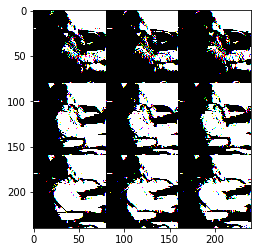

In [53]:
plt.imshow(np.array(x[0]).reshape((240, 240, 3))*255)

In [58]:
np.array(x[0]).reshape((240, 240, 3))

array([[[-1.39424927, -1.41301296, -1.41573883],
        [-1.38087057, -1.27092681, -1.31738023],
        [-1.37210751, -1.31855918, -1.28745369],
        ...,
        [ 1.04581067,  1.03385382,  1.04540957],
        [ 1.03750766,  1.03882026,  1.04591087],
        [ 1.0448242 ,  1.0469645 ,  1.04910506]],

       [[-1.33929203, -1.32026078, -1.33534954],
        [-1.3003307 , -1.26098058, -1.30691968],
        [-1.33126896, -1.23694071, -1.31687854],
        ...,
        [ 1.09867348,  1.05432294,  1.03305085],
        [ 1.02448834,  1.03251571,  1.05139632],
        [ 1.06114624,  1.0600757 ,  1.05900542]],

       [[-1.29992941, -1.31083303, -1.32023156],
        [-1.3403247 , -1.33319219, -1.31242173],
        [-1.27327228, -1.29337381, -1.32217145],
        ...,
        [ 1.40044711,  1.3628194 ,  1.34041821],
        [ 1.30099299,  1.25572261,  1.1858022 ],
        [ 1.14184494,  1.10807201,  1.08643188]],

       ...,

       [[-1.55335513, -1.56084422, -1.57214595],
        [-1

In [57]:
im

array([[[119, 152, 109],
        [123, 156, 113],
        [129, 160, 118],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[124, 155, 113],
        [125, 156, 114],
        [126, 157, 115],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[140, 171, 130],
        [137, 168, 127],
        [133, 164, 123],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[  7,   8,   3],
        [  7,   8,   3],
        [  8,   9,   4],
        ...,
        [ 48,  52,  53],
        [ 47,  51,  52],
        [ 46,  50,  51]],

       [[  9,  10,   5],
        [  8,   9,   4],
        [  7,   8,   3],
        ...,
        [ 48,  52,  53],
        [ 47,  51,  52],
        [ 46,  50,  51]],

       [[ 10,  11,   6],
        [  9,  10,   5],
        [  7,   8,   3],
        ...,
        [ 48,  52,  53],
        [ 47,  51,  52],
        [ 46,  50,  51]]